# Finetuning SBERT for Semantic search using MNR loss

In this notebook we will finetune the bert-base model for semantic search using Multiple Negative Ranking loss.

This will be mostly similar to the finetuning we did in the previous notebook. The main changes are:
- We won't use a fully connected layer on top of the embeddings now
- We will use Multiple Negative Ranking loss
- We will compute cosine similarity between the pooled u and v embedding and use that in MNR

MNR loss
> This loss expects as input a batch consisting of sentence pairs (a_1, p_1), (a_2, p_2)..., (a_n, p_n) where we assume that (a_i, p_i) are a positive pair and (a_i, p_j) for i!=j a negative pair.
>
> For each a_i, it uses all other p_j as negative samples, i.e., for a_i, we have 1 positive example (p_i) and n-1 negative examples (p_j). It then minimizes the negative log-likehood for softmax normalized scores. This loss function works great to train embeddings for retrieval setups where you have positive pairs (e.g. (query, relevant_doc)) as it will sample in each batch n-1 negative docs randomly.
>
> The performance usually increases with increasing batch sizes.
>
> For more information, see: https://arxiv.org/pdf/1705.00652.pdf<br>
(Efficient Natural Language Response Suggestion for Smart Reply, Section 4.4)
>
> You can also provide one or multiple hard negatives per anchor-positive pair by structering the data like this: (a_1, p_1, n_1), (a_2, p_2, n_2)
>
> Here, n_1 is a hard negative for (a_1, p_1). The loss will use for the pair (a_i, p_i) all p_j (j!=i) and all n_j as negatives.
>
> Source: https://github.com/UKPLab/sentence-transformers/blob/master/sentence_transformers/losses/MultipleNegativesRankingLoss.py

We will just use the (anchor, postive) pairs in our training here. We will discuss hard negatives later in the series.

Since we just need the (achor, positive) pairs, we will filter the snli dataset with label=0 for entails.

In [1]:
import datasets

dataset = datasets.load_dataset("snli", split="train")
dataset = dataset.filter(lambda x: True if x["label"] == 0 else False)

len(dataset), dataset[0]

Reusing dataset snli (/home/utsav/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b)
Loading cached processed dataset at /home/utsav/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b/cache-737deef8acadbdc5.arrow


(183416,
 {'premise': 'A person on a horse jumps over a broken down airplane.',
  'hypothesis': 'A person is outdoors, on a horse.',
  'label': 0})

Let's look at an example of MNR loss using (anchor, positive) pairs per batch, based on the description provided by the sentence_transformers library.

In [2]:
import torch

batch_size = 8

anchors, positives = [], []
for i in range(batch_size):
    anchors.append(dataset[i]["premise"])
    positives.append(dataset[i]["hypothesis"])

In [3]:
anchors

['A person on a horse jumps over a broken down airplane.',
 'Children smiling and waving at camera',
 'A boy is jumping on skateboard in the middle of a red bridge.',
 'Two blond women are hugging one another.',
 'A few people in a restaurant setting, one of them is drinking orange juice.',
 'An older man is drinking orange juice at a restaurant.',
 'A man with blond-hair, and a brown shirt drinking out of a public water fountain.',
 'Two women who just had lunch hugging and saying goodbye.']

In [4]:
positives

['A person is outdoors, on a horse.',
 'There are children present',
 'The boy does a skateboarding trick.',
 'There are women showing affection.',
 'The diners are at a restaurant.',
 'A man is drinking juice.',
 'A blond man drinking water from a fountain.',
 'There are two woman in this picture.']

Here we will use a fintuned model to try and show an example with good represenatations for the sentences instead of using random gibberish values.

In [5]:
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer("all-MiniLM-L6-v2")
loss_fn = torch.nn.CrossEntropyLoss()

In [6]:
anchor_encodings = model.encode(anchors)
postiive_encodings = model.encode(positives)

similarity_matrix = util.cos_sim(anchor_encodings, postiive_encodings)
target = torch.tensor(range(len(anchor_encodings)), dtype=torch.long)

In [11]:
import numpy as np

np.round(similarity_matrix, 2), target

(tensor([[ 0.6000, -0.0400,  0.0800, -0.1300, -0.0000,  0.0900,  0.1500, -0.0200],
         [-0.1100,  0.5900,  0.1600,  0.2100,  0.1200, -0.1600, -0.0900,  0.0600],
         [ 0.1200,  0.1200,  0.6400, -0.2200, -0.0500,  0.0500, -0.0000, -0.1100],
         [-0.0900,  0.1200, -0.1900,  0.6700,  0.0900, -0.1400,  0.0900,  0.5800],
         [-0.0300,  0.0800, -0.0100,  0.0400,  0.5000,  0.4900,  0.2300,  0.1300],
         [ 0.0200, -0.1400,  0.0500, -0.1700,  0.3400,  0.6100,  0.3000, -0.1500],
         [ 0.1800, -0.1100, -0.0200, -0.1300,  0.0200,  0.5100,  0.8700, -0.1300],
         [-0.2000,  0.0900, -0.2500,  0.6100,  0.2800, -0.1000, -0.0800,  0.5300]]),
 tensor([0, 1, 2, 3, 4, 5, 6, 7]))

Here, each row in the similarity_matrix can be thought of as unnormalized scores for a class and each entry in the target array corresponds to the corresponding class label for that similarity row. The diagonal entries are our (anchor, postive) pairs hence they have the highest scores(this won't be the case with a bert-base model which hasn't been finetuned for STS, we observe this behaviour here since we are using a model finetuned on STS tasks).

In [12]:
loss_fn(similarity_matrix, target)

tensor(1.6082)

In [13]:
import random
from typing import Callable, Iterable

import datasets
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
from transformers import BertTokenizerFast, BertModel
from transformers.optimization import get_linear_schedule_with_warmup
from scipy import stats
from sklearn.metrics.pairwise import cosine_similarity

In [14]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

Let's start ...

## Data preparation

We will create a custom dataset for the that will give us postive and negative pairs.

In [15]:
%%time

MAX_LENGTH = 128

# anchors
tokenized_premises = tokenizer([data["premise"] for data in dataset],
                               max_length=MAX_LENGTH, padding="max_length",
                               truncation=True, verbose=True)
# postives
tokenized_hypothesis = tokenizer([data["hypothesis"] for data in dataset],
                                 max_length=MAX_LENGTH, padding="max_length",
                                 truncation=True, verbose=True)

CPU times: user 45.1 s, sys: 22.4 s, total: 1min 7s
Wall time: 31 s


In [16]:
seed = 10

random.seed(seed)
np.random.seed(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Now we will create out custom dataset and dataloaders with train/validation split for training.

In [17]:
class SnliDataset(Dataset):
    def __init__(self, premise_tokens: dict, hypothesis_tokens: dict):
        self.premise_tokens = premise_tokens
        self.hypothesis_tokens = hypothesis_tokens
        self._init_data()

    def _init_data(self):
        self.data = []
        for pt_ids, pt_am, ht_ids, ht_am in zip(
            self.premise_tokens["input_ids"], self.premise_tokens["attention_mask"],
            self.hypothesis_tokens["input_ids"], self.hypothesis_tokens["attention_mask"],
        ):
            data = {}
            data["premise_input_ids"] = torch.tensor(pt_ids, dtype=torch.long)
            data["premise_attention_mask"] = torch.tensor(pt_am, dtype=torch.long)
            data["hypothesis_input_ids"] = torch.tensor(ht_ids, dtype=torch.long)
            data["hypothesis_attention_mask"] = torch.tensor(ht_am, dtype=torch.long)
            self.data.append(data)

    def __getitem__(self, ix: int):
        return self.data[ix]

    def __len__(self):
        return len(self.data)

In [18]:
%%time

snli_dataset = SnliDataset(tokenized_premises, tokenized_hypothesis)

CPU times: user 4.11 s, sys: 242 ms, total: 4.36 s
Wall time: 4.35 s


In [19]:
train_ratio = 0.8
n_total = len(snli_dataset)
n_train = int(n_total * train_ratio)
n_val = n_total - n_train

train_dataset, val_dataset = random_split(snli_dataset, [n_train, n_val])

batch_size = 16  # mentioned in the paper
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [20]:
next(iter(train_dataloader))

{'premise_input_ids': tensor([[  101,  1996,  2611,  ...,     0,     0,     0],
         [  101,  1037,  2158,  ...,     0,     0,     0],
         [  101,  1037,  2177,  ...,     0,     0,     0],
         ...,
         [  101,  1037,  2711,  ...,     0,     0,     0],
         [  101,  2019,  3080,  ...,     0,     0,     0],
         [  101, 16031, 25711,  ...,     0,     0,     0]]),
 'premise_attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'hypothesis_input_ids': tensor([[  101,  1996,  2611,  ...,     0,     0,     0],
         [  101,  1037,  2158,  ...,     0,     0,     0],
         [  101,  1037,  2235,  ...,     0,     0,     0],
         ...,
         [  101,  1037,  2711,  ...,     0,     0,     0],
         [  101,  2093,  2111,  ...,     0,     0,     0],
         [  101, 27467, 

## Model config

Here we will setup out custom SBERT model as detailed in the diagram from the paper.

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

The method mean_pool() implements the mean token pooling strategy mentioned in the paper. The implementation has been picked up from the sentente_transformers library.

We will use the encode() method to compute pooled embeddings using the finetuned and the bert-base models later to evaluate the results on STS tasks.

In [22]:
def mean_pool(token_embeds: torch.tensor, attention_mask: torch.tensor) -> torch.tensor:
    in_mask = attention_mask.unsqueeze(-1).expand(token_embeds.size()).float()
    pool = torch.sum(token_embeds * in_mask, 1) / torch.clamp(in_mask.sum(1), min=1e-9)
    return pool


def encode(
    input_texts: list[str], tokenizer: BertTokenizerFast, model: BertModel, device: str = "cpu"
) -> torch.tensor:

    model.eval()
    tokenized_texts = tokenizer(input_texts, max_length=MAX_LENGTH,
                                padding='max_length', truncation=True, return_tensors="pt")
    token_embeds = model(tokenized_texts["input_ids"].to(device),
                         tokenized_texts["attention_mask"].to(device)).last_hidden_state
    pooled_embeds = mean_pool(token_embeds, tokenized_texts["attention_mask"].to(device))
    return pooled_embeds

In [23]:
class Sbert(torch.nn.Module):
    def __init__(self, max_length: int = MAX_LENGTH):
        super().__init__()
        self.max_length = max_length
        self.bert_model = BertModel.from_pretrained('bert-base-uncased')
        self.bert_tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')


    def forward(self, data: datasets.arrow_dataset.Dataset) -> torch.tensor:
        premise_input_ids = data["premise_input_ids"].to(device)
        premise_attention_mask = data["premise_attention_mask"].to(device)
        hypothesis_input_ids = data["hypothesis_input_ids"].to(device)
        hypothesis_attention_mask = data["hypothesis_attention_mask"].to(device)

        out_premise = self.bert_model(premise_input_ids, premise_attention_mask)
        out_hypothesis = self.bert_model(hypothesis_input_ids, hypothesis_attention_mask)
        premise_embeds = out_premise.last_hidden_state
        hypothesis_embeds = out_hypothesis.last_hidden_state

        pooled_premise_embeds = mean_pool(premise_embeds, premise_attention_mask)
        pooled_hypotheses_embeds = mean_pool(hypothesis_embeds, hypothesis_attention_mask)

        return pooled_premise_embeds, pooled_hypotheses_embeds

In [24]:
model = Sbert()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [25]:
#  optimizer, lr, num_warmup steps have been picked from the paper
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
total_steps = len(train_dataset) // batch_size
warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps,
                                            num_training_steps=total_steps - warmup_steps)

loss_fn = torch.nn.CrossEntropyLoss()

In [26]:
model = model.to(device)

## Training loop

While calculating the loss per batch, using the similarity matrix(from anchors and positives) and the target tensor, we scale the similarty matrix by a constant first. We are using a scaling factor of 20 as used in the sentence_tranformer library.

The reason for this scaling(from what i can tell) is the same as using temperature while decoding from seq2seq models. Essentially we want to make the distribution of scores(similarity in this case) more peaky(this amouts to lowering the temperature while decoding).

For example, consider a batch size 4 with similarity scores [0.8, 0.75, 0.5, 0.4] with `similarity(anchor, positve)` = 0.8.

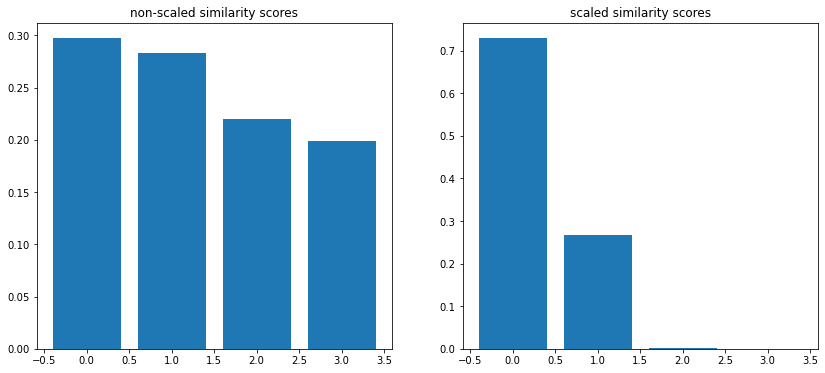

In [32]:
similarity_scores = np.array([0.8, 0.75, 0.5, 0.4])
softmax_scores = np.exp(similarity_scores) / np.exp(similarity_scores).sum()
scaled_softmax_scores = np.exp(similarity_scores*20) / np.exp(similarity_scores*20).sum()

fix, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].bar(range(len(softmax_scores)), softmax_scores)
ax[0].set_title("non-scaled similarity scores")
ax[1].bar(range(len(scaled_softmax_scores)), scaled_softmax_scores)
ax[1].set_title("scaled similarity scores");

In [21]:
def get_train_step_fn(
    model: torch.nn.Module, optimizer: torch.optim.Optimizer, 
    scheduler: torch.optim.lr_scheduler.LambdaLR, loss_fn: torch.nn.CrossEntropyLoss
) -> Callable:

    def train_step_fn(x: torch.tensor) -> float:
        model.train()
        anchor_encodings, positive_encodings = model(x)
        similarity_matrix = util.cos_sim(anchor_encodings, positive_encodings)
        target = torch.tensor(range(len(anchor_encodings)), dtype=torch.long, device=device)
        loss = loss_fn(similarity_matrix * 20, target)
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        return loss.item()

    return train_step_fn


def get_val_step_fn(model: torch.nn.Module, loss_fn: torch.nn.CrossEntropyLoss) -> Callable:

    def val_step_fn(x: torch.tensor) -> float:
        model.eval()
        anchor_encodings, postiive_encodings = model(x)
        similarity_matrix = util.cos_sim(anchor_encodings, postiive_encodings)
        target = torch.tensor(range(len(anchor_encodings)), dtype=torch.long, device=device)
        loss = loss_fn(similarity_matrix * 20, target)
        return loss.item()

    return val_step_fn


def mini_batch(
    dataloader: DataLoader, step_fn: Callable, is_training: bool = True
) -> tuple[np.array, list[float]]:

    mini_batch_losses = []

    if is_training:
        print("\nTraining ...")
    else:
        print("\nValidating ...")
    n_steps = len(dataloader)
    for i, data in enumerate(dataloader):
        loss = step_fn(data)
        mini_batch_losses.append(loss)
        if i % (batch_size * 100) == 0:
            print(f"step {i:>5}/{n_steps}, loss = {loss: .3f}")

    return np.mean(mini_batch_losses), mini_batch_losses

In [22]:
%%time

n_epochs = 1  # mentioned in the paper

train_step_fn = get_train_step_fn(model, optimizer, scheduler, loss_fn)
val_step_fn = get_val_step_fn(model, loss_fn)

train_losses, train_mini_batch_losses = [], []
val_losses, val_mini_batch_losses = [], []

for epoch in range(1, n_epochs + 1):
    train_loss, _train_mini_batch_losses = mini_batch(train_dataloader, train_step_fn)
    train_mini_batch_losses += _train_mini_batch_losses
    train_losses.append(train_loss)

    with torch.no_grad():
        val_loss, _val_mini_batch_losses = mini_batch(val_dataloader, val_step_fn, is_training=False)
        val_mini_batch_losses += _val_mini_batch_losses
        val_losses.append(val_loss)


Training ...
step     0/9171, loss =  1.716
step  1600/9171, loss =  0.286
step  3200/9171, loss =  0.055
step  4800/9171, loss =  0.172
step  6400/9171, loss =  0.037
step  8000/9171, loss =  0.266

Validating ...
step     0/2293, loss =  0.122
step  1600/2293, loss =  0.043
CPU times: user 20min 46s, sys: 6min 21s, total: 27min 7s
Wall time: 27min 3s


In [23]:
train_loss, val_loss

(0.176284230241434, 0.1142814209404556)

Normally we look at losses over multiple epochs, but here we have only 1 epoch. One way to look at the mini batch losses is to use a running mean(smoothing) to reduce noise from per batch loss.

In [24]:
window_size = 32

train_mb_running_loss = []
for i in range(len(train_mini_batch_losses)-window_size):
    train_mb_running_loss.append(np.mean(train_mini_batch_losses[i:i+window_size]))

val_mb_running_loss = []
for i in range(len(val_mini_batch_losses)-window_size):
    val_mb_running_loss.append(np.mean(val_mini_batch_losses[i:i+window_size]))

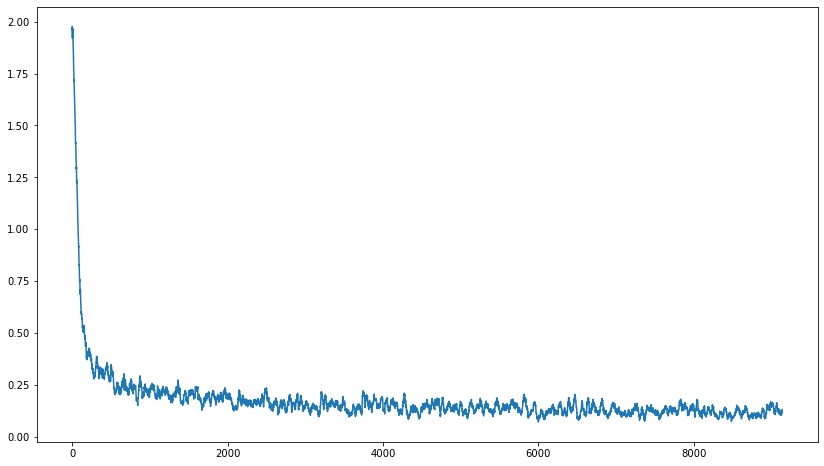

In [25]:
fix, ax = plt.subplots(figsize=(14, 8))
ax.plot(range(len(train_mb_running_loss)), train_mb_running_loss);

## Evaluation

Here we will manually inspect the performance of our finetuned model as well as use a STS dataset for evaluation on a similar task as mentioned in the paper.

For manual inspection, we have taken few texts which fall neatly into three clusters. We want to see how neatly our finetuned model(and the bert-base model) is able to find these clusters.

In [26]:
def plot_heatmap(similarity_matrix: np.array, sentences: list[str]) -> None:
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(similarity_matrix, cmap='YlGn', interpolation='nearest')

    ax.set_yticks(np.arange(len(sentences)), labels=[txt[:50] + "..." for txt in sentences])
    ax.set_xticks(np.arange(len(sentences)), labels=[txt[:50] + "..." for txt in sentences])

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    for i in range(len(sentences)):
        for j in range(len(sentences)):
            text = ax.text(j, i, round(similarity_matrix[i, j], 2),
                           ha="center", va="center", color="w")

    fig.tight_layout()
    plt.show()

In [27]:
sentences = [
    "What should I do to improve my English ?",
    "What should I do to improve my spoken English?",
    "Can I improve my English?",
    "How can I earn money online?",
    "How do I earn money online?",
    "Can I earn money online?",
    "What are some mind-blowing Mobile gadgets that exist that most people don't know about?",
    "What are some mind-blowing gadgets and technologies that exist that most people don't know about?",
    "What are some mind-blowing mobile technology tools that exist that most people don't know about?"
]

In [28]:
pooled_embeds = encode(sentences, model.bert_tokenizer, model.bert_model, device)
pooled_embeds = pooled_embeds.cpu().detach().numpy()

Our finetuned model.

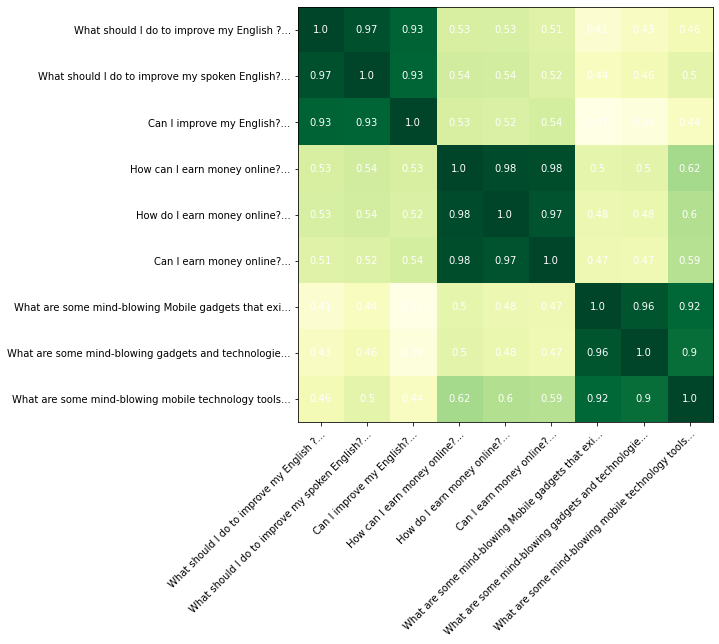

In [29]:
similarity_matrix = cosine_similarity(pooled_embeds)
plot_heatmap(similarity_matrix, sentences)

Next we import the original bert-base model again for comparison.

In [30]:
bert_model = BertModel.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [31]:
pooled_embeds = encode(sentences, tokenizer, bert_model, "cpu")
pooled_embeds = pooled_embeds.detach().numpy()

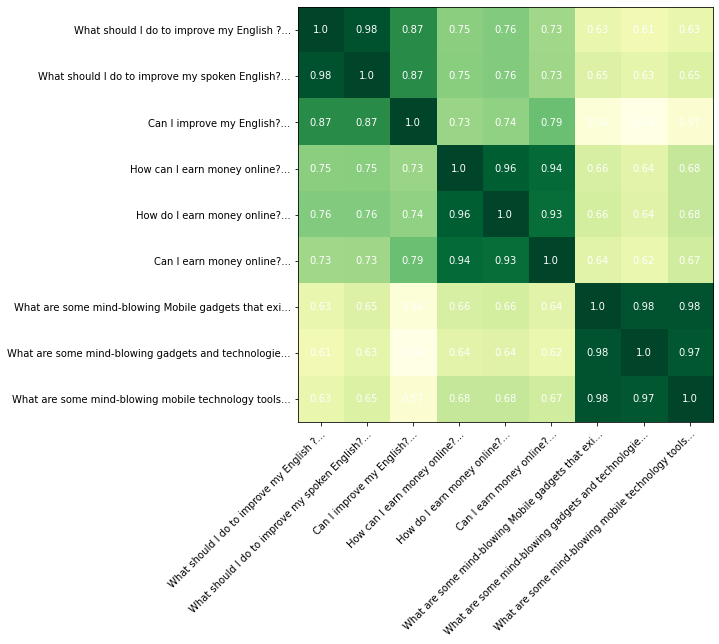

In [32]:
similarity_matrix = cosine_similarity(pooled_embeds)
plot_heatmap(similarity_matrix, sentences)

On a visual inspection we can see that our finetuned model is doing a better job in encoding the texts so that the clusters are clearly visible. Specifically it's doing a better job in pusing down the scores for non similar text pairs.

Let's evaluate the models on a STS dataset.

In [33]:
sbert_model = model.bert_model
bert_model = bert_model.to(device)

In [34]:
sts = datasets.load_dataset("glue", "stsb", split="validation")
len(sts), sts[0]

Reusing dataset glue (/home/utsav/.cache/huggingface/datasets/glue/stsb/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


(1500,
 {'sentence1': 'A man with a hard hat is dancing.',
  'sentence2': 'A man wearing a hard hat is dancing.',
  'label': 5.0,
  'idx': 0})

In [35]:
sentence1s = [data["sentence1"] for data in sts]
sentence2s = [data["sentence2"] for data in sts]
normalized_labels = [data["label"] / 5 for data in sts]

In [36]:
def cos_sim_in_batches(
    batch_size: int, s1_texts: list[str], s2_texts: list[str],
    tokenizer: BertTokenizerFast, model: BertModel, cos_sim_f: Callable
) -> torch.tensor:

    cos_sims = None
    n_batches = len(s1_texts) // batch_size + int(len(s1_texts) % batch_size != 0)
    for i in range(n_batches):
        s1_batch = s1_texts[i*batch_size: (i+1)*batch_size]
        s2_batch = s2_texts[i*batch_size: (i+1)*batch_size]
        if i == 0:
            cos_sims = cos_sim_f(encode(s1_batch, tokenizer, model, "cuda").detach(),
                                 encode(s2_batch, tokenizer, model, "cuda").detach())
        else:
            _cos_sims = cos_sim_f(encode(s1_batch, tokenizer, model, "cuda").detach(),
                                  encode(s2_batch, tokenizer, model, "cuda").detach())
            cos_sims = torch.cat([cos_sims, _cos_sims])
    
    return cos_sims

In [37]:
cos_sim_f = torch.nn.CosineSimilarity()
sbert_cos_sims = cos_sim_in_batches(16, sentence1s, sentence2s, tokenizer, sbert_model, cos_sim_f)
bert_cos_sims = cos_sim_in_batches(16, sentence1s, sentence2s, tokenizer, bert_model, cos_sim_f)

In [38]:
stats.spearmanr(sbert_cos_sims.cpu().detach().numpy(), np.array(normalized_labels))

SpearmanrResult(correlation=0.8134930507240802, pvalue=0.0)

In [39]:
stats.spearmanr(bert_cos_sims.cpu().detach().numpy(), np.array(normalized_labels))

SpearmanrResult(correlation=0.5931769556210932, pvalue=3.0261969816970313e-143)

Our finetuned model using MNR loss is doing even better than the model we finetuned in the previous notebook using the classification objective, with lesser training data and steps as well.

| Model | Spearman rank correlation |
| ----- | ------------------------- |
| sbert fintuned with MNR loss | `0.81` |
| sbert with classification objective | `0.79` |
| bert-base |`0.59`|

---

## References

[1]  https://github.com/UKPLab/sentence-transformers/